# Brain Tumor Classification

## Data Loading

In [23]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

BASE_DIR = 'combined_dataset'
TRAIN_VAL_SPLIT = 0.8

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, 'Training'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, 'Testing'), transform=transform)

# Splitting the dataset into training and validation
train_size = int(TRAIN_VAL_SPLIT * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## CNN Model

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 4)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
from torch import nn
import matplotlib.pyplot as plt

def train_model(model, train_loader, valid_loader, num_epochs=10, learning_rate=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        print("CUDA")
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("MPS")
        device = torch.device("mps")
    else:
        print("CPU")
        device = torch.device("cpu")

    model = model.to(device)
    
    # Lists to track the losses and accuracies
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        average_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(average_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # No gradients needed for validation
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        average_val_loss = running_val_loss / len(valid_loader)
        val_accuracy = 100 * correct_val / total_val
        valid_losses.append(average_val_loss)
        valid_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch + 1}, Train Loss: {average_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {average_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies


def save_model(model, directory="models"):
    os.makedirs(directory, exist_ok=True)
    
    highest_num = 0
    for filename in os.listdir(directory):
        if filename.startswith("model_") and filename.endswith(".pth"):
            num = int(filename.split('_')[1].split('.')[0])
            if num > highest_num:
                highest_num = num
    
    model_filename = f"model_{highest_num + 1}.pth"
    model_path = os.path.join(directory, model_filename)
    
    torch.save(model.state_dict(), model_path)
    print(f"Model saved as {model_filename} in directory '{directory}'.")


def load_model(model, model_number = None, directory="models"):
    if model_number is None:
        model_number = 0
        for filename in os.listdir(directory):
            if filename.startswith("model_") and filename.endswith(".pth"):
                num = int(filename.split('_')[1].split('.')[0])
                if num > model_number:
                    model_number = num

    model_filename = f"model_{model_number}.pth"
    model_path = os.path.join(directory, model_filename)
    if not os.path.exists(model_path):
        print(f"No model found with the name {model_filename} in directory '{directory}'.")
        return None
    model.load_state_dict(torch.load(model_path))
    print(f"Model loaded from {model_filename}.")
    return model


def test_model(model, test_loader):
    model.eval()  
    criterion = nn.CrossEntropyLoss()  

    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    model = model.to(device)

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


def plot_metric(train_metric, valid_metric, metric_name, save_path='figures/img.png'):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metric, label=f'Training {metric_name}')
    plt.plot(valid_metric, label=f'Validation Loss {metric_name}')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.savefig(save_path)

### Training

In [10]:
model = CNN()  # Assuming CNN is your model class
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, train_loader, validation_loader)

MPS
Epoch 1, Train Loss: 0.6858, Train Acc: 73.90%, Val Loss: 0.3820, Val Acc: 85.26%
Epoch 2, Train Loss: 0.2721, Train Acc: 89.99%, Val Loss: 0.2004, Val Acc: 92.43%
Epoch 3, Train Loss: 0.1243, Train Acc: 95.35%, Val Loss: 0.1736, Val Acc: 94.76%
Epoch 4, Train Loss: 0.0695, Train Acc: 97.74%, Val Loss: 0.1528, Val Acc: 94.93%
Epoch 5, Train Loss: 0.0420, Train Acc: 98.60%, Val Loss: 0.1813, Val Acc: 95.46%
Epoch 6, Train Loss: 0.0434, Train Acc: 98.76%, Val Loss: 0.2043, Val Acc: 95.28%
Epoch 7, Train Loss: 0.0290, Train Acc: 99.13%, Val Loss: 0.1736, Val Acc: 95.86%
Epoch 8, Train Loss: 0.0044, Train Acc: 99.87%, Val Loss: 0.2405, Val Acc: 94.18%
Epoch 9, Train Loss: 0.0051, Train Acc: 99.83%, Val Loss: 0.1798, Val Acc: 96.74%
Epoch 10, Train Loss: 0.0086, Train Acc: 99.66%, Val Loss: 0.1802, Val Acc: 95.81%


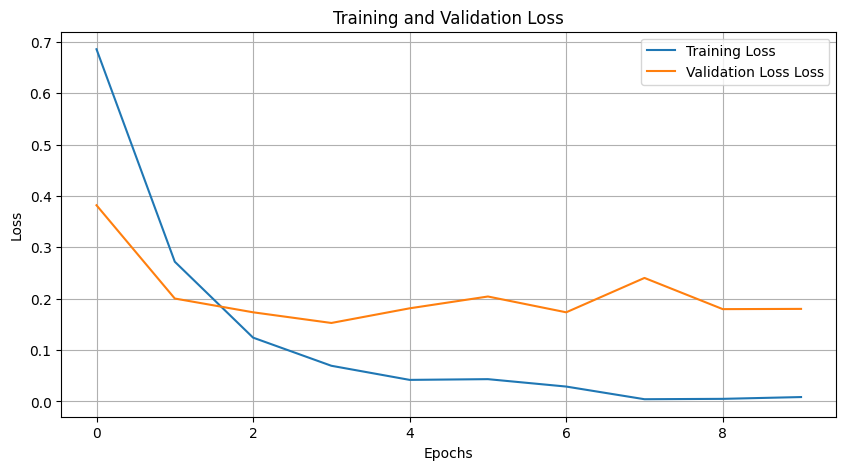

<Figure size 640x480 with 0 Axes>

In [27]:
# Now plot the losses
plot_metric(train_losses, valid_losses, 'Loss')

### Testing Model and Test Dataset

In [28]:
test_model(model, test_loader)
save_model(model)

Test Loss: 1.5891, Test Accuracy: 90.38%


In [21]:
### Loads and tests latest model
testing_model = CNN()
testing_model = load_model(testing_model)   # Specify model number if you want to load an older model: load_model(testing_model, 1)
test_model(testing_model, test_loader)

Model loaded from model_3.pth.
Test Loss: 1.5891, Test Accuracy: 90.38%


In [22]:
!pip3 install torchviz

In [18]:
from torchviz import make_dot

def visualize_model(model, input_size=(3, 150, 150)):
    # Create a dummy input tensor with the correct size
    dummy_input = torch.randn(1, *input_size, requires_grad=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dummy_input = dummy_input.to(device)
    model = model.to(device)
    
    # Forward pass through the model
    output = model(dummy_input)
    
    # Create dot graph of the model
    dot = make_dot(output, params=dict(list(model.named_parameters()) + [('input', dummy_input)]))
    return dot

# Example usage:
dot = visualize_model(model)
dot.render('model_visualization', format='png', cleanup=True)  # This saves the diagram as a PNG

'model_visualization.png'